In [1]:
import numpy as np
import random
import json

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
from nltk_utils import bag_of_words, tokenize, stem
from model import NeuralNet

In [4]:
with open('intents.json', 'r') as f:
    intents = json.load(f)

In [5]:
all_words = []
tags = []
xy = []
# loop through each sentence in our intents patterns
for intent in intents['intents']:
    tag = intent['tag']
    # add to tag list
    tags.append(tag)
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = tokenize(pattern)
        # add to our words list
        all_words.extend(w)
        # add to xy pair
        xy.append((w, tag))

In [6]:
# stem and lower each word
ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
# remove duplicates and sort
all_words = sorted(set(all_words))
tags = sorted(set(tags))

In [7]:
print(len(xy), "patterns")
print(len(tags), "tags:", tags)
print(len(all_words), "unique stemmed words:", all_words)

50 patterns
15 tags: ['complaint', 'delivery', 'feedback', 'funny', 'goodbye', 'greeting', 'help', 'history', 'items', 'order_status', 'payments', 'recommendation', 'science', 'thanks', 'weather']
117 unique stemmed words: ["'m", "'s", ',', '1969', '20', 'a', 'about', 'accept', 'an', 'ani', 'anyon', 'are', 'assist', 'atom', 'bye', 'can', 'card', 'cash', 'complaint', 'credit', 'day', 'deliveri', 'do', 'doe', 'einstein', 'explain', 'faulti', 'feedback', 'first', 'for', 'funni', 'get', 'give', 'good', 'goodby', 'happen', 'have', 'hello', 'help', 'hey', 'hi', 'how', 'i', 'ii', 'is', 'it', 'item', 'joke', 'juli', 'kind', 'know', 'later', 'leav', 'light', 'like', 'long', 'lot', 'mastercard', 'me', 'my', 'need', 'not', 'of', 'on', 'onli', 'order', 'outsid', 'packag', 'pay', 'paypal', 'pleas', 'presid', 'product', 'rain', 'recommend', 'rel', 'review', 'satisfi', 'see', 'sell', 'servic', 'ship', 'should', 'someth', 'speed', 'state', 'statu', 'structur', 'suggest', 'sunni', 'take', 'tell', 'than

In [8]:
# create training data
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    # X: bag of words for each pattern_sentence
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    # y: PyTorch CrossEntropyLoss needs only class labels, not one-hot
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [9]:
# Hyper-parameters 
num_epochs = 1000
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)
print(input_size, output_size)

117 15


In [10]:
class ChatDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [11]:
dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNet(input_size, hidden_size, output_size).to(device)

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
!pip install matplotlib


  Using cached matplotlib-3.8.3-cp39-cp39-win_amd64.whl.metadata (5.9 kB)
  Using cached contourpy-1.2.0-cp39-cp39-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.49.0-cp39-cp39-win_amd64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.5-cp39-cp39-win_amd64.whl.metadata (6.5 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_resources-6.1.2-py3-none-any.whl.metadata (3.9 kB)
Using cached matplotlib-3.8.3-cp39-cp39-win_amd64.whl (7.6 MB)
Using cached contourpy-1.2.0-cp39-cp39-win_amd64.whl (181 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.49.0-cp39-cp39-win_amd64.whl (2.2 MB)
Using cached importlib_resources-6.1.2-py3-none-any.whl (34 kB)
Using cached kiwisolver-1.4.5-cp39-cp39-win_amd64.whl (56 kB)
Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)


Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0001
Epoch [300/1000], Loss: 0.0001
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000


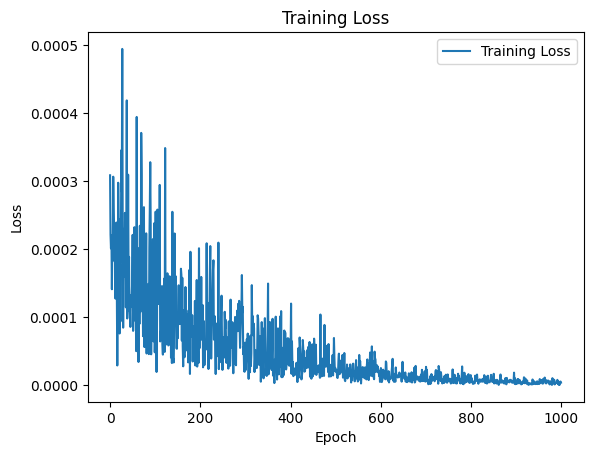

In [17]:
import matplotlib.pyplot as plt

# Lists to store the loss values for visualization
train_losses = []

# Train the model
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        outputs = model(words)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
    # Append the loss to the list for visualization
    train_losses.append(loss.item())

# Visualize the training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


In [18]:
print(f'final loss: {loss.item():.4f}')

data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tags
}

FILE = "data.pth"
torch.save(data, FILE)

print(f'training complete. file saved to {FILE}')

final loss: 0.0000
training complete. file saved to data.pth


In [20]:
!pip install scikit-learn

  Using cached scikit_learn-1.4.1.post1-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.12.0-cp39-cp39-win_amd64.whl.metadata (60 kB)
  Using cached threadpoolctl-3.3.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.4.1.post1-cp39-cp39-win_amd64.whl (10.6 MB)
Using cached scipy-1.12.0-cp39-cp39-win_amd64.whl (46.2 MB)
Using cached threadpoolctl-3.3.0-py3-none-any.whl (17 kB)


Epoch [50/500], Loss: 0.9818, Training Accuracy: 0.8413
Epoch [100/500], Loss: 0.0197, Training Accuracy: 0.9810
Epoch [150/500], Loss: 0.0189, Training Accuracy: 0.9937
Epoch [200/500], Loss: 0.0090, Training Accuracy: 0.9937
Epoch [250/500], Loss: 0.0006, Training Accuracy: 0.9937
Epoch [300/500], Loss: 0.0004, Training Accuracy: 0.9937
Epoch [350/500], Loss: 0.0001, Training Accuracy: 0.9937
Epoch [400/500], Loss: 0.0000, Training Accuracy: 0.9937
Epoch [450/500], Loss: 0.0001, Training Accuracy: 0.9937
Epoch [500/500], Loss: 0.0000, Training Accuracy: 0.9937


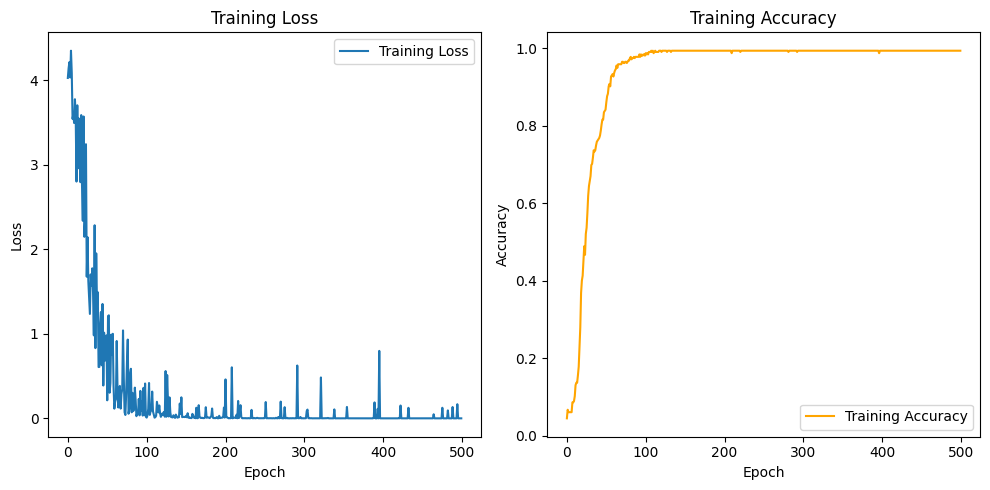

Final Training Accuracy: 0.9937
Training complete. Model saved to data.pth
Confusion Matrix:
[[6 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 8 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 4]]
Classification Report:


ValueError: Number of classes, 63, does not match size of target_names, 64. Try specifying the labels parameter

In [16]:
import numpy as np
import random
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from nltk_utils import bag_of_words, tokenize, stem
from model import NeuralNet
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load intents from JSON file
with open('val.json', 'r') as f:
    intents = json.load(f)

# Extract words and tags from intents
all_words = []
tags = []
xy = []
for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w, tag))

# Preprocess words (stemming, removing duplicates)
ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

# Create training data
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Hyper-parameters
num_epochs = 500
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)

# Define custom Dataset class
class ChatDataset(Dataset):
    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples

# Create DataLoader
dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss function, and optimizer
model = NeuralNet(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training loss and accuracy for visualization
train_losses = []
train_accuracies = []

# Train the model
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        outputs = model(words)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate training accuracy
    # Get predictions on the training set
    X_train_tensor = torch.tensor(X_train).to(device)
    with torch.no_grad():
        train_outputs = model(X_train_tensor)
        _, predicted = torch.max(train_outputs, 1)

    # Calculate training accuracy
    train_accuracy = accuracy_score(y_train, predicted.cpu().numpy())

    # Append loss and accuracy for visualization
    train_losses.append(loss.item())
    train_accuracies.append(train_accuracy)
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}')

# Plot training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate final training accuracy
# Calculate final training accuracy
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train).to(device)  # Convert to tensor
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(train_outputs, 1)
    final_train_accuracy = accuracy_score(y_train, predicted.cpu().numpy())


# Print final training accuracy
print(f'Final Training Accuracy: {final_train_accuracy:.4f}')

# Save model and related information
data = {
    "model_state": model.state_dict(),
    "input_size": input_size,
    "hidden_size": hidden_size,
    "output_size": output_size,
    "all_words": all_words,
    "tags": tags
}

FILE = "data.pth"
torch.save(data, FILE)

print(f'Training complete. Model saved to {FILE}')

# Evaluation Metric
# Get predictions on the training set
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train).to(device)  # Convert to tensor
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(train_outputs, 1)


# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_train, predicted.cpu().numpy()))

# Print classification report
print("Classification Report:")
print(classification_report(y_train, predicted.cpu().numpy(), target_names=tags))


Epoch [500/500], Loss: 0.0001, Val Loss: 0.0000, Val Accuracy: 0.0000
Final Validation Accuracy: 0.0000, Final Validation Loss: 0.0000


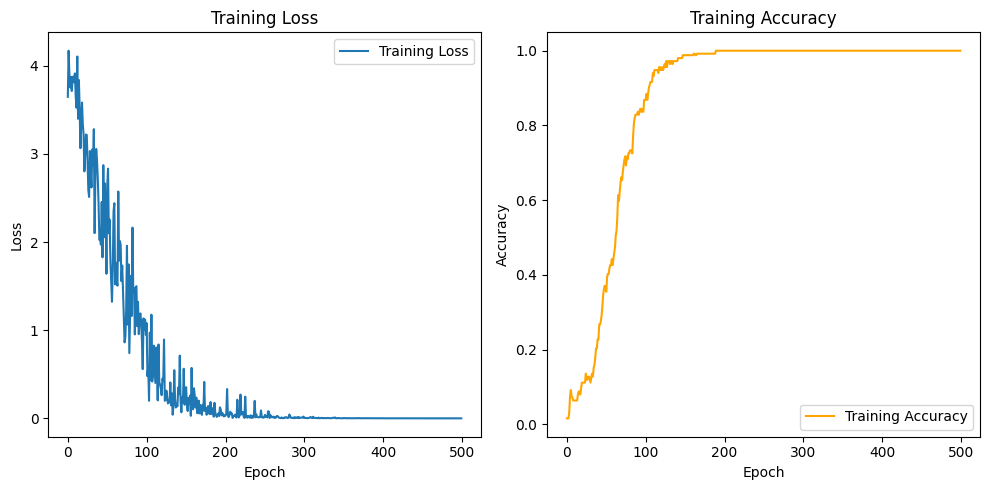

Final Training Accuracy: 1.0000
Training complete. Model saved to data.pth
Confusion Matrix:
[[6 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 6 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 8]]
Classification Report:


ValueError: Number of classes, 41, does not match size of target_names, 52. Try specifying the labels parameter

Epoch [50/500], Loss: 1.6029, Accuracy: 0.6951
Epoch [100/500], Loss: 1.3410, Accuracy: 0.8784
Epoch [150/500], Loss: 0.0027, Accuracy: 0.9321
Epoch [200/500], Loss: 0.4474, Accuracy: 0.9731
Epoch [250/500], Loss: 0.0613, Accuracy: 0.9905
Epoch [300/500], Loss: 0.0841, Accuracy: 0.9921
Epoch [350/500], Loss: 0.0005, Accuracy: 0.9921
Epoch [400/500], Loss: 0.1606, Accuracy: 0.9921
Epoch [450/500], Loss: 0.0016, Accuracy: 0.9921
Epoch [500/500], Loss: 0.0000, Accuracy: 0.9921


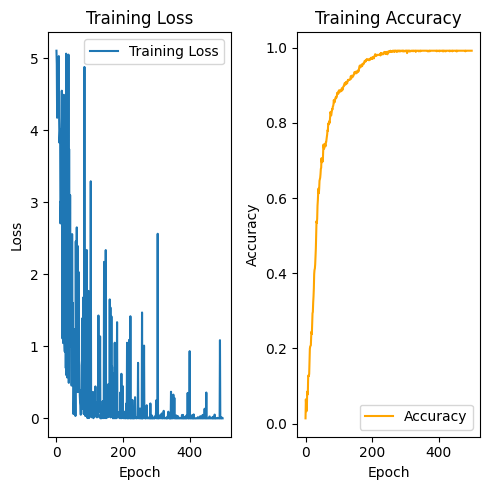

Final Training Accuracy: 0.9921
Training complete. Model saved to data.pth
Confusion Matrix:
[[ 8  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  8  0  0]
 [ 0  0  0 ...  0 16  0]
 [ 0  0  0 ...  0  0  4]]
Classification Report:


ValueError: Number of classes, 128, does not match size of target_names, 129. Try specifying the labels parameter

In [3]:
import numpy as np
import random
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from nltk_utils import bag_of_words, tokenize, stem
from model import NeuralNet
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load intents from JSON file
with open('intents.json', 'r') as f:
    intents = json.load(f)

# Extract words and tags from intents
all_words = []
tags = []
xy = []
for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w, tag))

# Preprocess words (stemming, removing duplicates)
ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

# Create training data
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Hyper-parameters
num_epochs = 500
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 4
output_size = len(tags)

# Define custom Dataset class
class ChatDataset(Dataset):
    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples

# Create DataLoader
dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss function, and optimizer
model = NeuralNet(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training loss and accuracy for visualization
train_losses = []
train_accuracies = []

# Train the model
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        outputs = model(words)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate training accuracy
    # Get predictions on the training set
    X_train_tensor = torch.tensor(X_train).to(device)
    with torch.no_grad():
        train_outputs = model(X_train_tensor)
        _, predicted = torch.max(train_outputs, 1)

    # Calculate training accuracy
    train_accuracy = accuracy_score(y_train, predicted.cpu().numpy())

    # Append loss and accuracy for visualization
    train_losses.append(loss.item())
    train_accuracies.append(train_accuracy)
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}')

# Plot training loss and accuracy
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate final training accuracy
# Calculate final training accuracy
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train).to(device)  # Convert to tensor
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(train_outputs, 1)
    final_train_accuracy = accuracy_score(y_train, predicted.cpu().numpy())


# Print final training accuracy
print(f'Final Training Accuracy: {final_train_accuracy:.4f}')

# Save model and related information
data = {
    "model_state": model.state_dict(),
    "input_size": input_size,
    "hidden_size": hidden_size,
    "output_size": output_size,
    "all_words": all_words,
    "tags": tags
}

FILE = "data.pth"
torch.save(data, FILE)

print(f'Training complete. Model saved to {FILE}')

# Evaluation Metric
# Get predictions on the training set
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train).to(device)  # Convert to tensor
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(train_outputs, 1)


# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_train, predicted.cpu().numpy()))

# Print classification report
print("Classification Report:")
print(classification_report(y_train, predicted.cpu().numpy(), target_names=tags))


Epoch [50/500], Loss: 3.2174, Accuracy: 0.5366
Epoch [100/500], Loss: 0.9563, Accuracy: 0.8298
Epoch [150/500], Loss: 1.1080, Accuracy: 0.9188
Epoch [200/500], Loss: 0.4904, Accuracy: 0.9476
Epoch [250/500], Loss: 0.5804, Accuracy: 0.9607
Epoch [300/500], Loss: 0.0011, Accuracy: 0.9843
Epoch [350/500], Loss: 0.0003, Accuracy: 0.9895
Epoch [400/500], Loss: 0.0022, Accuracy: 0.9895
Epoch [450/500], Loss: 0.0004, Accuracy: 0.9895
Epoch [500/500], Loss: 0.0010, Accuracy: 0.9895


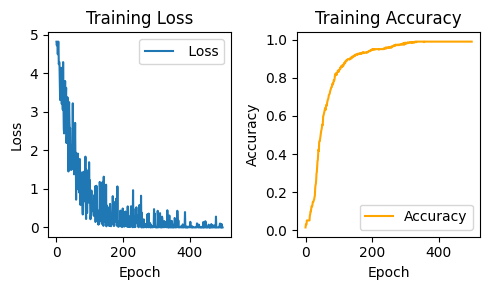

Final Training Accuracy: 0.9895
Training complete. Model saved to data.pth
Confusion Matrix:
[[6 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 8 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 4]]
Classification Report:


ValueError: Number of classes, 122, does not match size of target_names, 123. Try specifying the labels parameter

In [26]:
import numpy as np
import random
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from nltk_utils import bag_of_words, tokenize, stem
from model import NeuralNet
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load intents from JSON file
with open('intentssanchita.json', 'r') as f:
    intents = json.load(f)

# Extract words and tags from intents
all_words = []
tags = []
xy = []
for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w, tag))

# Preprocess words (stemming, removing duplicates)
ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

# Create training data
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Hyper-parameters
num_epochs = 500
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 6
output_size = len(tags)

# Define custom Dataset class
class ChatDataset(Dataset):
    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples

# Create DataLoader
dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss function, and optimizer
model = NeuralNet(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training loss and accuracy for visualization
train_losses = []
train_accuracies = []

# Train the model
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        outputs = model(words)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate training accuracy
    # Get predictions on the training set
    X_train_tensor = torch.tensor(X_train).to(device)
    with torch.no_grad():
        train_outputs = model(X_train_tensor)
        _, predicted = torch.max(train_outputs, 1)

    # Calculate training accuracy
    train_accuracy = accuracy_score(y_train, predicted.cpu().numpy())

    # Append loss and accuracy for visualization
    train_losses.append(loss.item())
    train_accuracies.append(train_accuracy)
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}')

# Plot training loss and accuracy
plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label=' Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate final training accuracy
# Calculate final training accuracy
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train).to(device)  # Convert to tensor
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(train_outputs, 1)
    final_train_accuracy = accuracy_score(y_train, predicted.cpu().numpy())


# Print final training accuracy
print(f'Final Training Accuracy: {final_train_accuracy:.4f}')

# Save model and related information
data = {
    "model_state": model.state_dict(),
    "input_size": input_size,
    "hidden_size": hidden_size,
    "output_size": output_size,
    "all_words": all_words,
    "tags": tags
}

FILE = "data.pth"
torch.save(data, FILE)

print(f'Training complete. Model saved to {FILE}')

# Evaluation Metric
# Get predictions on the training set
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train).to(device)  # Convert to tensor
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(train_outputs, 1)


# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_train, predicted.cpu().numpy()))

# Print classification report
print("Classification Report:")
print(classification_report(y_train, predicted.cpu().numpy(), target_names=tags))


In [ ]:
import numpy as np
import random
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from nltk_utils import bag_of_words, tokenize, stem
from model import NeuralNet

with open('intents.json', 'r') as f:
    intents = json.load(f)

all_words = []
tags = []
xy = []
# loop through each sentence in our intents patterns
for intent in intents['intents']:
    tag = intent['tag']
    # add to tag list
    tags.append(tag)
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = tokenize(pattern)
        # add to our words list
        all_words.extend(w)
        # add to xy pair
        xy.append((w, tag))

# stem and lower each word
ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
# remove duplicates and sort
all_words = sorted(set(all_words))
tags = sorted(set(tags))

print(len(xy), "patterns")
print(len(tags), "tags:", tags)
print(len(all_words), "unique stemmed words:", all_words)

# create training data
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    # X: bag of words for each pattern_sentence
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    # y: PyTorch CrossEntropyLoss needs only class labels, not one-hot
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Hyper-parameters 
num_epochs = 1000
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 1
output_size = len(tags)
print(input_size, output_size)

class ChatDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNet(input_size, hidden_size, output_size).to(device)

# Loss and optimizer

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        outputs = model(words)
        # if y would be one-hot, we must apply
        # labels = torch.max(labels, 1)[1]
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


print(f'final loss: {loss.item():.4f}')

data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tags
}

FILE = "data.pth"
torch.save(data, FILE)

print(f'training complete. file saved to {FILE}')


642 patterns
129 tags: ['AES', 'ARP', 'Antivirus Software', 'Biometric Authentication', 'Blockchain Technology', 'Botnet', 'Cognitive Cybersecurity', 'Common Threats', 'Cryptography', 'Cyber_insurance', 'Cyber_security_frameworks', 'Cybersecurity Measures', 'DDoS Attack', 'DES', 'DNS Security', 'Data Breach', 'Data Exfiltration', 'Data Loss Prevention', 'Data Masking', 'Data_encryption', 'Decryption', 'Detecting Computer Hacks', 'Diffie-Hellman', 'Encryption', 'Encryption Key Management', 'Encryption different from Hashing', 'Endpoint Security', 'Endpoint_security', 'Firewall', 'Forward Secrecy', 'Grey hat hackers', 'Hashing', 'Home Network Security', 'Identity', 'Identity_theft_protection', 'Incident_response', 'Insider Threats', 'Intrusion_detection_system', 'IoT Device Security', 'Malware', 'Mitigating Insider Threats', 'Mobile Device Security', 'Multi-Factor Authentication', 'Multipartite Virus', 'Network Segmentation', 'Network_security', 'Penetration Testing', 'Phishing preventio

In [ ]:
import numpy as np
import random
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from nltk_utils import bag_of_words, tokenize, stem
from model import NeuralNet

with open('intents.json', 'r') as f:
    intents = json.load(f)

all_words = []
tags = []
xy = []
# loop through each sentence in our intents patterns
for intent in intents['intents']:
    tag = intent['tag']
    # add to tag list
    tags.append(tag)
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = tokenize(pattern)
        # add to our words list
        all_words.extend(w)
        # add to xy pair
        xy.append((w, tag))

# stem and lower each word
ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
# remove duplicates and sort
all_words = sorted(set(all_words))
tags = sorted(set(tags))

print(len(xy), "patterns")
print(len(tags), "tags:", tags)
print(len(all_words), "unique stemmed words:", all_words)